In [36]:
%matplotlib inline

from pathlib import Path
import time
import traceback
from importlib import reload

from umap import UMAP
import numpy as np
import scipy.stats as stats
import pandas as pd
pd.set_option('display.max_rows', 50)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

from TreeMazeAnalyses2.Analyses import subject_info as si
from TreeMazeAnalyses2.Analyses import cluster_match_functions as cmf

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.covariance import MinCovDet

from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']


In [2]:
%%time
si = reload(si)
subjects = ['Cl']
overwrite = False
for subject in subjects:
    subject_info = si.SubjectInfo(subject, overwrite=overwrite)
    #subject_info.update_clusters()

CPU times: user 58.8 ms, sys: 3.78 ms, total: 62.6 ms
Wall time: 61.1 ms


### show #s of curated cell/mua on each tt per session

In [3]:
subject_info.sort_tables['curated']

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Cl_T3g_010218,1,2,1,10,0,0,0,1,0,6,0,0,0,0,1,0
Cl_OF_010218,0,4,1,7,0,0,0,0,0,9,0,1,3,0,1,0
Cl_T3g_010318,0,2,2,2,0,0,0,0,0,4,0,0,0,0,1,0
Cl_OF_010318,0,2,6,3,0,0,0,1,0,8,1,2,0,0,0,1
Cl_OF_010418,0,0,9,8,0,0,0,0,0,6,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cl_T3i_021419,0,6,0,14,0,0,0,0,0,2,0,1,0,0,0,0
Cl_T3g_021519,0,3,0,7,0,0,0,0,0,2,0,0,0,0,0,0
Cl_OF_021519,0,5,0,8,0,0,0,0,0,0,0,0,0,0,0,0
Cl_T3i_021519,0,4,0,7,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
%%time
#subject_info.update_clusters()

## select cluster match analyses based on isolated cells
these analayses are based on matching tetrode depths across sessions, example:

In [4]:
%%time
analyses = []
for tt in np.arange(1,17):
    tt_depths = list(subject_info.tt_depth_match[tt].keys())
    for tt_d in tt_depths:
        tt_d_sessions = subject_info.tt_depth_match[tt][tt_d]
        # check if there are more 2 or more sessions with units
        n_cells_session = np.zeros(len(tt_d_sessions),dtype=int)
        for ii, session in enumerate(tt_d_sessions):
            session_cell_IDs = subject_info.session_clusters[session]['cell_IDs']
            if tt in session_cell_IDs.keys():
                n_cells_session[ii] = len(session_cell_IDs[tt])
        sessions_with_cells = np.where(n_cells_session>0)[0]
        if len(sessions_with_cells)>=2:
            analyses.append( (tt, 
                              tt_d, 
                              np.array(tt_d_sessions)[sessions_with_cells].tolist(), 
                              n_cells_session[sessions_with_cells].tolist())
                           )


CPU times: user 9.16 ms, sys: 194 µs, total: 9.36 ms
Wall time: 8.89 ms


In [5]:
analyses[12]

(4, 12.0, ['Cl_T3g_112118_0001', 'Cl_OF_112118'], [1, 4])

## Wrappper for cluster matching analyses

In [38]:
%%time
cmf  = reload(cmf)

cluster_match_results = {k: {} for k in np.arange(len(analyses))}
rng =0

dim_reduc_method = 'umap'
dist_metric = 'pe'
dist_metric_thr = 0.5

n_wf = 1000
n_samps = 32*4

for analysis_id, analysis in enumerate(analyses):

    np.random.seed(rng)
    
    t0 = time.time()
    tt, d, sessions, n_session_units = analysis

    n_total_units = np.sum(n_session_units)
    print(f"Analysis {analysis_id}. tt {tt}, depth {d}, num of units {n_total_units}, num sessions {len(sessions)} \n")

    # Step 1. Load Data & waveforms for each session
    X = np.empty((0,n_wf,n_samps),dtype=np.float16)
    for session in sessions:
        cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
        session_cell_wf = subject_info.get_session_tt_wf(session, tt, cluster_ids=cluster_ids, n_wf=n_wf)
        X = np.concatenate((X,session_cell_wf),axis=0)

    n_clusters = np.array(n_session_units).sum()
    cluster_labels = np.arange(n_clusters).repeat(n_wf)
    
    # Obtain cluster label names
    cl_names = []
    for session_num, session in enumerate(sessions):
        cluster_ids = subject_info.session_clusters[session]['cell_IDs'][tt]
        for cl_num, cl_id in enumerate(cluster_ids):
            cl_name = f"{session}-cl{cl_id}"        
            cl_names.append(cl_name)

    t1 = time.time()
    print(f"Time to load data: {t1-t0:0.2f}s")

    # Step 2. Reduce Dimensions of the data
    X_2d = cmf.dim_reduction(X.reshape(-1, X.shape[-1]), method=dim_reduc_method)

    t2 = time.time()
    print(f"Dim Reduction: {t2-t1:0.2f}s")

    # Step 3. Obtain moments and determine cluster distances on new space
    clusters_mean, clusters_cov = cmf.get_clusters_moments(data=X_2d, labels=cluster_labels) 
    dist_mats = cmf.get_clusters_all_dists(clusters_mean, clusters_cov, data=X_2d, labels=cluster_labels)

    # Step 4. Determine unique matches based on metric 
    dists_mats_df = {}
    for metric, dist_mat in dist_mats.items():
        dists_mats_df[metric] =  pd.DataFrame(dist_mat, index=cl_names, columns=cl_names)    
    unique_matches = cmf.find_unique_session_cl_matches(dists_mats_df[dist_metric], thr=dist_metric_thr, session_cl_sep="-")
    unique_sets = cmf.matches_dict_to_unique_sets(unique_matches)

    t3 = time.time()
    print(f"Unique matches: {len(unique_sets)}\n")


    cluster_match_results[analysis_id] = { 'clusters_loc': clusters_mean, 'clusters_cov': clusters_cov, 'cl_names': cl_names, 
                                          'dists_mats': dists_mats_df, 'unique_matches': unique_matches, 'unique_sets': unique_sets}


    print(f"\n Analysis {analysis_id} completed.\n Total Time {t3-t0:0.2f}s \n\n")

#print(f' n sessions {len(sessions)} \n n clusters {n_clusters} \n Data Shape {X.shape} \n Clusters Shape {cluster_labels.shape} \n Session Shape {session_labels.shape}') 

Analysis 0. tt 1, depth 12.0, num of units 2, num sessions 2 

Time to load data: 0.13s
Dim Reduction: 5.60s
Unique matches: 2


 Analysis 0 completed.
 Total Time 6.57s 


Analysis 1. tt 1, depth 12.25, num of units 2, num sessions 2 

Time to load data: 0.26s
Dim Reduction: 6.15s
Unique matches: 2


 Analysis 1 completed.
 Total Time 7.39s 


Analysis 2. tt 2, depth 12.0, num of units 7, num sessions 2 

Time to load data: 0.13s
Dim Reduction: 9.72s
Unique matches: 6


 Analysis 2 completed.
 Total Time 13.01s 


Analysis 3. tt 2, depth 12.25, num of units 5, num sessions 3 

Time to load data: 0.78s
Dim Reduction: 8.63s
Unique matches: 5


 Analysis 3 completed.
 Total Time 11.66s 


Analysis 4. tt 2, depth 12.5, num of units 15, num sessions 5 

Time to load data: 2.23s
Dim Reduction: 9.51s
Unique matches: 10


 Analysis 4 completed.
 Total Time 18.42s 


Analysis 5. tt 2, depth 12.75, num of units 16, num sessions 6 

Time to load data: 2.74s
Dim Reduction: 10.49s
Unique matches: 

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/cluster_match_functions.py:387: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(h2)


Unique matches: 22


 Analysis 14 completed.
 Total Time 35.07s 


Analysis 15. tt 4, depth 12.75, num of units 37, num sessions 10 

Time to load data: 4.71s
Dim Reduction: 25.70s
Unique matches: 24


 Analysis 15 completed.
 Total Time 47.12s 


Analysis 16. tt 4, depth 13.0, num of units 13, num sessions 5 

Time to load data: 1.66s
Dim Reduction: 8.53s
Unique matches: 8


 Analysis 16 completed.
 Total Time 15.56s 


Analysis 17. tt 4, depth 13.25, num of units 6, num sessions 3 

Time to load data: 0.84s
Dim Reduction: 10.15s
Unique matches: 4


 Analysis 17 completed.
 Total Time 13.64s 


Analysis 18. tt 4, depth 13.75, num of units 10, num sessions 4 

Time to load data: 1.53s
Dim Reduction: 13.63s


/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/cluster_match_functions.py:387: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(h2)


Unique matches: 7


 Analysis 18 completed.
 Total Time 19.82s 


Analysis 19. tt 4, depth 14.0, num of units 9, num sessions 4 

Time to load data: 1.42s
Dim Reduction: 13.63s
Unique matches: 7


 Analysis 19 completed.
 Total Time 18.77s 


Analysis 20. tt 4, depth 14.75, num of units 8, num sessions 3 

Time to load data: 1.40s
Dim Reduction: 10.99s
Unique matches: 6


 Analysis 20 completed.
 Total Time 15.91s 


Analysis 21. tt 4, depth 15.0, num of units 7, num sessions 3 

Time to load data: 0.69s
Dim Reduction: 9.53s
Unique matches: 5


 Analysis 21 completed.
 Total Time 13.26s 


Analysis 22. tt 4, depth 15.25, num of units 18, num sessions 6 

Time to load data: 1.87s
Dim Reduction: 11.10s
Unique matches: 12


 Analysis 22 completed.
 Total Time 20.88s 


Analysis 23. tt 4, depth 15.5, num of units 9, num sessions 3 

Time to load data: 1.06s
Dim Reduction: 12.07s
Unique matches: 6


 Analysis 23 completed.
 Total Time 16.91s 


Analysis 24. tt 4, depth 15.75, num of units 7

/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/cluster_match_functions.py:387: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(h2)


Unique matches: 2


 Analysis 34 completed.
 Total Time 7.97s 


Analysis 35. tt 10, depth 13.75, num of units 17, num sessions 9 

Time to load data: 3.49s
Dim Reduction: 11.81s
Unique matches: 12


 Analysis 35 completed.
 Total Time 22.98s 


Analysis 36. tt 10, depth 12.0, num of units 3, num sessions 2 

Time to load data: 0.30s
Dim Reduction: 9.45s
Unique matches: 3


 Analysis 36 completed.
 Total Time 10.91s 


Analysis 37. tt 10, depth 12.25, num of units 6, num sessions 3 

Time to load data: 1.08s
Dim Reduction: 9.11s


/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/cluster_match_functions.py:387: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(h2)


Unique matches: 5


 Analysis 37 completed.
 Total Time 12.98s 


Analysis 38. tt 10, depth 12.5, num of units 33, num sessions 14 

Time to load data: 5.91s
Dim Reduction: 20.78s
Unique matches: 24


 Analysis 38 completed.
 Total Time 40.97s 


Analysis 39. tt 10, depth 12.75, num of units 19, num sessions 9 

Time to load data: 2.82s
Dim Reduction: 11.66s
Unique matches: 11


 Analysis 39 completed.
 Total Time 22.55s 


Analysis 40. tt 10, depth 13.0, num of units 7, num sessions 4 

Time to load data: 1.85s
Dim Reduction: 10.49s
Unique matches: 4


 Analysis 40 completed.
 Total Time 15.62s 


Analysis 41. tt 10, depth 13.25, num of units 6, num sessions 4 

Time to load data: 1.30s
Dim Reduction: 9.55s
Unique matches: 3


 Analysis 41 completed.
 Total Time 13.52s 


Analysis 42. tt 10, depth 13.5, num of units 8, num sessions 4 

Time to load data: 1.67s
Dim Reduction: 10.93s


/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/cluster_match_functions.py:387: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(h2)


Unique matches: 4


 Analysis 42 completed.
 Total Time 16.07s 


Analysis 43. tt 10, depth 14.25, num of units 7, num sessions 3 

Time to load data: 1.84s
Dim Reduction: 10.93s
Unique matches: 5


 Analysis 43 completed.
 Total Time 15.88s 


Analysis 44. tt 10, depth 14.5, num of units 7, num sessions 3 

Time to load data: 0.86s
Dim Reduction: 9.83s
Unique matches: 6


 Analysis 44 completed.
 Total Time 13.97s 


Analysis 45. tt 10, depth 14.75, num of units 13, num sessions 6 

Time to load data: 1.93s
Dim Reduction: 8.94s
Unique matches: 9


 Analysis 45 completed.
 Total Time 16.79s 


Analysis 46. tt 10, depth 15.0, num of units 7, num sessions 3 

Time to load data: 1.33s
Dim Reduction: 9.71s


/home/alexgonzalez/Documents/TreeMazeAnalyses2/Analyses/cluster_match_functions.py:387: RuntimeWarning: invalid value encountered in sqrt
  h = np.sqrt(h2)


Unique matches: 5


 Analysis 46 completed.
 Total Time 14.04s 


Analysis 47. tt 10, depth 15.25, num of units 14, num sessions 7 

Time to load data: 3.13s
Dim Reduction: 9.21s
Unique matches: 9


 Analysis 47 completed.
 Total Time 18.65s 


Analysis 48. tt 12, depth 12.0, num of units 5, num sessions 2 

Time to load data: 0.22s
Dim Reduction: 7.71s
Unique matches: 5


 Analysis 48 completed.
 Total Time 9.94s 


Analysis 49. tt 12, depth 12.25, num of units 8, num sessions 3 

Time to load data: 1.23s
Dim Reduction: 10.43s
Unique matches: 7


 Analysis 49 completed.
 Total Time 14.88s 


Analysis 50. tt 12, depth 12.5, num of units 27, num sessions 8 

Time to load data: 3.67s
Dim Reduction: 15.81s
Unique matches: 17


 Analysis 50 completed.
 Total Time 31.20s 


Analysis 51. tt 12, depth 12.75, num of units 37, num sessions 10 

Time to load data: 5.23s
Dim Reduction: 21.18s
Unique matches: 23


 Analysis 51 completed.
 Total Time 42.64s 


Analysis 52. tt 12, depth 13.0, num of

## show results for last session

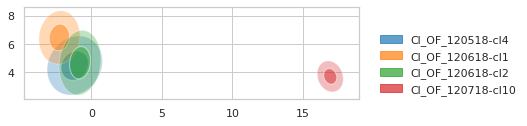

In [53]:
cmf = reload(cmf)
cmf.plot_2d_cluster_ellipsoids(clusters_loc=clusters_mean, clusters_cov=clusters_cov, legend=True, cl_names=cl_names)

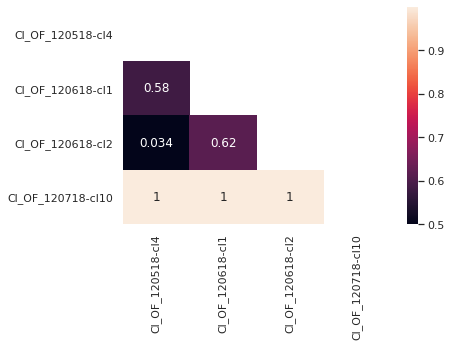

In [57]:
dist_metric = 'pe'
dist_metric_thr = 0.5
dm = dists_mats_df[dist_metric]

mask = np.triu(np.ones_like(dm, dtype=bool))
sns.heatmap(dm, mask=mask, annot=True, vmin=dist_metric_thr)

In [41]:
unique_sets

[{'Cl_OF_120518-cl4', 'Cl_OF_120618-cl2'},
 {'Cl_OF_120618-cl1'},
 {'Cl_OF_120718-cl10'}]

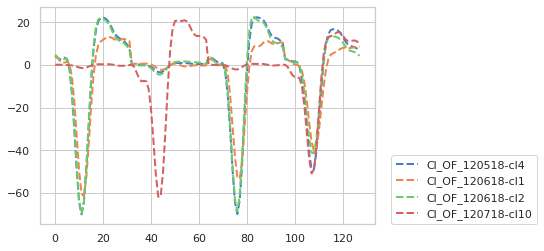

In [60]:
plt.plot(X.mean(axis=1).T, '--',linewidth=2)
plt.legend(cl_names, loc=(1.05,0))

## the algorithm correctly identified the orange and blue clusters to be the same across sessions